In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv()

# llm = ChatOpenAI(
#                     temperature=0,
#                     max_tokens=4096,
#                     presence_penalty=1.2,
#                     model='deepseek-chat',
#                     openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
#                     openai_api_base="https://api.deepseek.com/v1",
#                 )

model = ChatOllama(
                    temperature=0,
                    num_predict=4096,
                    repeat_penalty=1.2,
                    model="llama3.2:3b"
                )

embedding = HuggingFaceEmbeddings(
            model_name="../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define store

In [3]:
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore(
    index={
        "embed": embedding,
        "dims": 1536,
    }
)

# Create graph

In [4]:
import uuid
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# NOTE: we're passing the Store param to the node --
# this is the Store we compile the graph with
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([d.value["data"] for d in memories])
    system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

    # Store new memories if the user asks the model to remember
    last_message = state["messages"][-1]
    if "remember" in last_message.content.lower():
        memory = "User name is Bob"
        store.put(namespace, str(uuid.uuid4()), {"data": memory})

    response = model.invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

# NOTE: we're passing the store object here when compiling the graph
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)
# If you're using LangGraph Cloud or LangGraph Studio, you don't need to pass the store or checkpointer when compiling the graph, since it's done automatically.

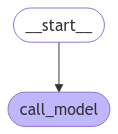

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Run the graph!

In [6]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {"type": "user", "content": "Hi! Remember: my name is Bob"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Bob
================================== Ai Message ==================================

Hello Bob! It's nice to chat with you again. I don't have any prior conversations stored, so we're starting fresh each time we talk. How can I assist you today?


In [10]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_message = {"type": "user", "content": "what is my name?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I think we've established this by now... Your username is "Bob". Is there anything else you'd like to chat about or any questions you have that I can try to answer for you?


In [11]:
for memory in in_memory_store.search(("memories", "1")):
    print(memory.value)

{'data': 'User name is Bob'}


In [12]:
config = {"configurable": {"thread_id": "3", "user_id": "2"}}
input_message = {"type": "user", "content": "what is my name?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I don't have any information about your identity, and our conversation just started. I'm happy to chat with you, but I won't be able to recall or access any personal details unless we establish a connection first.

Would you like to introduce yourself by sharing your name, or would you rather not share it?
